In [344]:
import warnings

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping
from optuna import logging
from optuna.distributions import CategoricalDistribution as CatDist
from optuna.distributions import FloatDistribution as FloatDist
from optuna.distributions import IntDistribution as IntDist
from optuna.exceptions import ExperimentalWarning
from optuna.integration import OptunaSearchCV
from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest, HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.pipeline import FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler

logging.set_verbosity(logging.WARNING)
warnings.filterwarnings("ignore", category=ExperimentalWarning)


In [297]:
numeric_cols = [  # I ignore categorical features.
    "pressure [MPa]",
    "mass_flux [kg/m2-s]",
    "x_e_out [-]",
    "D_e [mm]",
    "D_h [mm]",
    "length [mm]",
    "chf_exp [MW/m2]",
    "id",
]

synthetic = pd.read_csv("data/data.csv", index_col="id", usecols=numeric_cols)
originals = pd.read_csv("data/original.csv", index_col="id", usecols=numeric_cols)

synthetic.columns = synthetic.columns.str.replace(r"\s?\[.*?\]", "", regex=True)
originals.columns = originals.columns.str.replace(r"\s?\[.*?\]", "", regex=True)

assert np.all(synthetic.columns == originals.columns)


In [298]:
def remove_duplicates(data):
    return data[~(data.duplicated() & data.x_e_out.notna())]


In [299]:
def remove_outliers(
    data,
    x_e_out_force_remove=False,
    force_remove_threshold=-0.6,
    contamination="auto",
    random_state=None,
    **kwargs
):
    if x_e_out_force_remove:
        data = data.drop(data[data.x_e_out < force_remove_threshold].index)

    isolation_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        **kwargs,
    )

    data_notna = data[~data.isna().any(axis=1)]
    forest_result = isolation_forest.fit_predict(data_notna.to_numpy())
    outlier_ids = pd.Series(forest_result == -1, index=data_notna.index)
    data_ids = pd.Series(np.zeros_like(data.index), index=data.index, dtype=bool)

    return data[~(outlier_ids | data_ids)]


In [300]:
def fillna_within_groupby(data, by, cols_to_fill, strategy="mean"):
    strategy_func = getattr(pd.Series, strategy)
    filled = data.groupby(by)[cols_to_fill].transform(
        lambda x: x.fillna(strategy_func(x))
    )
    cols_to_join = np.setdiff1d(data.columns.to_list(), cols_to_fill)
    return filled.join(data[cols_to_join])


In [301]:
final_preprocess = make_pipeline(
    make_column_transformer(
        (
            StandardScaler(),
            ["pressure", "mass_flux"],
        ),
        (
            make_pipeline(
                FunctionTransformer(  # Because of better fit to normal distribution.
                    func=np.log,
                    inverse_func=np.exp,
                    feature_names_out="one-to-one",
                ),
                StandardScaler(),
            ),
            ["D_e", "D_h", "chf_exp"],
        ),
        (
            make_pipeline(
                FunctionTransformer(  # Because of better fit to normal distribution.
                    func=np.log,
                    inverse_func=np.exp,
                    feature_names_out="one-to-one",
                ),
                StandardScaler(),
            ),
            ["length"],
        ),
        remainder="drop",
        verbose_feature_names_out=False,
    ),
    KNNImputer(n_neighbors=20, weights="distance"),
)


In [302]:
preliminary_processed_data = (
    synthetic.pipe(remove_duplicates)
    .pipe(
        remove_outliers,
        x_e_out_force_remove=True,
        random_state=42,
        bootstrap=True,
    )
    .pipe(
        fillna_within_groupby,
        by="chf_exp",  # Because of correlations.
        cols_to_fill=["pressure", "mass_flux", "length"],
        strategy="mean",
    )
    .pipe(
        fillna_within_groupby,
        by="pressure",  # Because of correlations.
        cols_to_fill=["D_e", "D_h"],
        strategy="mean",
    )
)

X = pd.DataFrame(
    final_preprocess.fit_transform(preliminary_processed_data),
    columns=final_preprocess.get_feature_names_out(),
    index=preliminary_processed_data.index,
)
y = preliminary_processed_data.x_e_out

X_train = X[y.notna()].to_numpy()
y_train = y[y.notna()].to_numpy()

X_valid = final_preprocess.transform(originals)
y_valid = originals.x_e_out.to_numpy()

X_test = X[y.isna()].to_numpy()
X_test_ids = X[y.isna()].index


In [303]:
X_train_orig = np.concatenate([X_train, X_valid])
y_train_orig = np.concatenate([y_train, y_valid])

In [478]:
PATIENCE = 20

lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}

lgbm = LGBMRegressor(**lgbm_kwargs)
catboost = CatBoostRegressor(**catboost_kwargs)
hgbr = HistGradientBoostingRegressor(random_state=42)

scores = -cross_val_score(
    lgbm,
    X_train,
    y_train,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    error_score="raise",  # type: ignore
    # CatBoost.
    # fit_params=dict(
    #     eval_set=(X_valid, y_valid),
    #     early_stopping_rounds=PATIENCE,
    # )
    # LGBM.
    fit_params=dict(
        eval_set=(X_valid, y_valid),
        callbacks=[early_stopping(stopping_rounds=PATIENCE, verbose=False)],
    ),
)
pd.Series(scores).describe()


count    3.000000
mean     0.069360
std      0.001458
min      0.067972
25%      0.068601
50%      0.069230
75%      0.070054
max      0.070879
dtype: float64

## HGBR SEARCHING

In [361]:
hgbr_kwargs = {
    "random_state": 42,
    "early_stopping": True,
    "n_iter_no_change": PATIENCE,
    "learning_rate": 0.055,
    "max_iter": 2700,
    "max_depth": 6,
    "min_samples_leaf": 43,
    "max_leaf_nodes": 29,
    "l2_regularization": 0.35,
}

hgbr = HistGradientBoostingRegressor(**hgbr_kwargs)
hgbr_space = {
    "learning_rate": FloatDist(1e-3, 5e-1, log=True),
    "max_iter": IntDist(100, 3000, step=100),
    "max_depth": IntDist(2, 6),
    "min_samples_leaf": IntDist(32, 256),
    "max_leaf_nodes": IntDist(16, 64),
    "l2_regularization": FloatDist(1e-2, 1e2, log=True),
}
hgbr_opt = OptunaSearchCV(
    estimator=hgbr,
    param_distributions=hgbr_space,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_trials=100,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=42,
)
hgbr_opt.fit(X_train, y_train)


OptunaSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
               error_score='raise',
               estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                       learning_rate=0.055,
                                                       max_depth=6,
                                                       max_iter=2700,
                                                       n_iter_no_change=20,
                                                       random_state=42),
               n_jobs=-1, n_trials=100,
               param_distributions={'l2_regularization': FloatDistribution(high=100.0, log=True, low=0.01, step=None),
                                    'max_leaf_nodes': IntDistribution(high=64, log=False, low=16, step=1),
                                    'min_samples_leaf': IntDistribution(high=256, log=False, low=32, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

## LGBM SEARCHING

In [287]:
lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

lgbm = LGBMRegressor(**lgbm_kwargs)
lgbm_space = {
    "num_leaves": IntDist(16, 64),
    "max_depth": IntDist(2, 5),
    "learning_rate": FloatDist(1e-3, 5e-1, log=True),
    "n_estimators": IntDist(300, 3000, step=100),
    "min_split_gain": FloatDist(1e-3, 5e-1, log=True),
    "min_child_weight": FloatDist(1e-3, 5e-1, log=True),
    "min_child_samples": IntDist(32, 256, step=16),
    "subsample": FloatDist(0.2, 0.8),
    "colsample_bytree": FloatDist(0.2, 0.8),
    "importance_type": CatDist(["split", "gain"]),
    "reg_alpha": FloatDist(1e-2, 1e2, log=True),
    "reg_lambda": FloatDist(1e-2, 1e2, log=True),
}
lgbm_opt = OptunaSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_space,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_trials=3,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=42,
)
lgbm_opt.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[early_stopping(stopping_rounds=PATIENCE, verbose=False)],
)


OptunaSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
               error_score='raise',
               estimator=LGBMRegressor(colsample_bytree=0.6, learning_rate=0.12,
                                       max_depth=5, min_child_samples=32,
                                       min_child_weight=0.01,
                                       min_split_gain=0.001, n_estimators=1100,
                                       num_leaves=21, random_state=42,
                                       reg_alpha=0.1, reg_lambda=10.0,
                                       subsample=0.2),
               n_jobs=-1, n_trials=3,
               param_distr...
                                    'n_estimators': IntDistribution(high=3000, log=False, low=300, step=100),
                                    'num_leaves': IntDistribution(high=64, log=False, low=16, step=1),
                                    'reg_alpha': FloatDistribution(high=100.0, log=True, low=0.01, step=None),
                                    'reg_lambda': FloatDistribution(high=100.0, log=True, low=0.01, step=None),
                                    'subsample': FloatDistribution(high=0.8, log=False, low=0.2, step=None)},
               random_state=42, scoring='neg_root_mean_squared_error')

## CATBOOST SEARCHING

In [ ]:
catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}

catboost = CatBoostRegressor(**catboost_kwargs)
catboost_space = {
    "iterations": IntDist(300, 3000, step=300),
    "learning_rate": FloatDist(5e-4, 5e-1, log=True),
    "depth": IntDist(2, 10),
    "l2_leaf_reg": FloatDist(1e-2, 1e2, log=True),
    "colsample_bylevel": FloatDist(1e-2, 9e-1, log=True),
    "min_data_in_leaf": IntDist(32, 256, step=16),
    "random_strength": FloatDist(1e-2, 1e1, log=True),
    "bagging_temperature": FloatDist(1e-2, 1e2, log=True),
}
cat_boost_opt = OptunaSearchCV(
    estimator=catboost,
    param_distributions=catboost_space,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_trials=3,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=42,
)
cat_boost_opt.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=PATIENCE,
)


## ENSEMBLE TEST

In [369]:
lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}

hgbr_kwargs = {
    "random_state": 42,
    "early_stopping": True,
    "n_iter_no_change": PATIENCE,
    "learning_rate": 0.055,
    "max_iter": 2700,
    "max_depth": 6,
    "min_samples_leaf": 43,
    "max_leaf_nodes": 29,
    "l2_regularization": 0.35,
}

PATIENCE = 20
SPLITS = 3

lgbm = LGBMRegressor(**lgbm_kwargs)
catboost = CatBoostRegressor(**catboost_kwargs)
hgbr = HistGradientBoostingRegressor(**hgbr_kwargs)
kfold = KFold(n_splits=SPLITS, shuffle=True, random_state=42)
y_true, y_pred, rmses = [], [], []


for k, (train_ids, test_ids) in enumerate(kfold.split(X_train, y_train)):

    X_train_k, y_train_k = X_train[train_ids], y_train[train_ids]
    X_test_k, y_test_k = X_train[test_ids], y_train[test_ids]

    lgbm.fit(
        X_train_k,
        y_train_k,
        eval_set=(X_valid, y_valid),
        callbacks=[
            early_stopping(stopping_rounds=PATIENCE, verbose=False),
        ],
    )

    catboost.fit(
        X_train_k,
        y_train_k,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=PATIENCE,
    )

    hgbr.fit(X_train_k, y_train_k)

    predictions = (
        lgbm.predict(X_test_k) + catboost.predict(X_test_k) + hgbr.predict(X_test_k)
    ) / 3
    predictions = predictions.round(4)  # Post-processing trick.

    y_true.append(y_test_k)
    y_pred.append(predictions)
    rmses.append(mean_squared_error(y_test_k, predictions, squared=False))


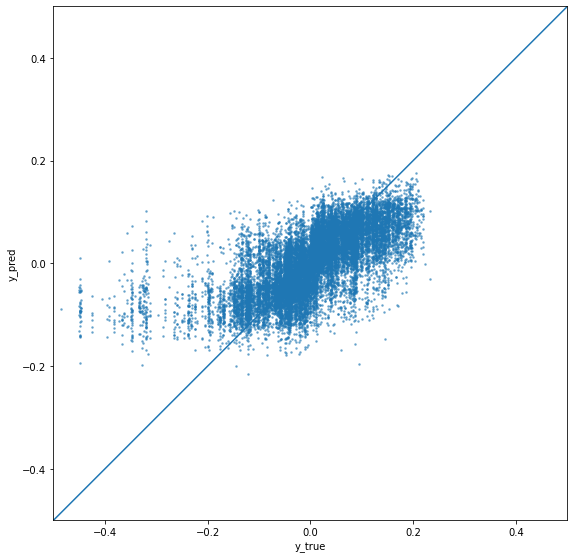

In [367]:
from matplotlib import pyplot as plt

Y_true = np.concatenate(y_true)
Y_pred = np.concatenate(y_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
ax.scatter(x=Y_true, y=Y_pred, alpha=0.5, marker=".", s=10)
ax.plot([-1, 1], [-1, 1])
ax.set_aspect(1.0)
ax.set_xlabel("y_true")
ax.set_ylabel("y_pred")
ax.axis([-0.5, 0.5, -0.5, 0.5])
plt.show()


In [371]:
pd.Series(rmses).describe()

count    3.000000
mean     0.069146
std      0.001480
min      0.067732
25%      0.068376
50%      0.069021
75%      0.069853
max      0.070684
dtype: float64

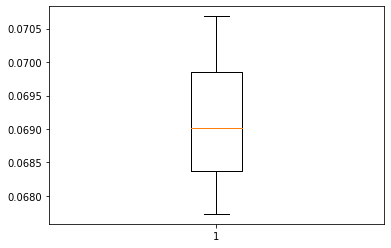

In [372]:
plt.boxplot(rmses)
plt.show()

## SUBMISSION

In [314]:
lgbm.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    callbacks=[
        early_stopping(stopping_rounds=PATIENCE, verbose=False),
    ],
)

catboost.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=PATIENCE,
)

predictions = ((lgbm.predict(X_test) + catboost.predict(X_test)) * 0.5).round(4)

submission = pd.DataFrame(
    {
        "id": X_test_ids,
        "x_e_out [-]": predictions,
    }
).set_index("id")

submission.to_csv("submission.csv")
submission.head()


,x_e_out [-]
id,
4,-0.0085
7,-0.0681
10,-0.0519
12,0.0019
23,0.0395


<AxesSubplot:ylabel='Frequency'>

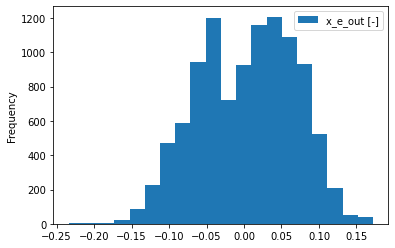

In [244]:
submission.plot(kind="hist", bins=20)

In [451]:
submission.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])


,x_e_out [-]
count,10415.000000
mean,0.004206
std,0.068364
min,-0.345400
1%,-0.151600
5%,-0.108560
25%,-0.047100
50%,0.009800
75%,0.057900
95%,0.106400


<AxesSubplot:xlabel='id'>

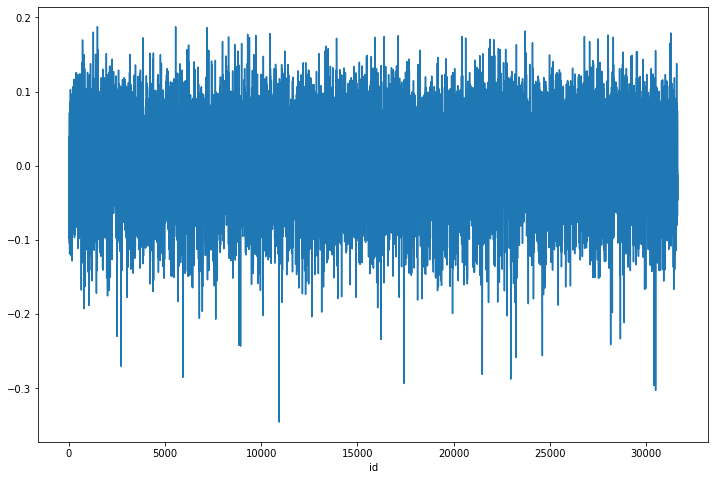

In [482]:
submission["x_e_out [-]"].plot(figsize=(12,8))

In [483]:
submission[submission["x_e_out [-]"] < -0.3]

,x_e_out [-]
id,
10931,-0.3454
30498,-0.3027


In [484]:
synthetic.iloc[[10931, 30498]]

,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
id,,,,,,,
10931,13.79,7893.0,NaN,NaN,4.7,318.0,11.0
30498,13.79,6700.0,NaN,4.7,4.7,318.0,10.9


In [485]:
synthetic.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
count,27192.000000,26853.000000,21229.000000,26156.000000,27055.000000,26885.000000,31644.000000
mean,10.640747,3068.011023,-0.000453,8.629255,14.174330,832.987391,3.796985
std,4.333683,1777.032080,0.100911,5.185692,19.838489,672.299239,1.983991
min,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
1%,0.100000,553.000000,-0.347600,1.900000,1.900000,10.000000,1.100000
5%,3.450000,819.000000,-0.148800,1.900000,1.900000,100.000000,1.600000
25%,6.890000,1519.000000,-0.046600,5.000000,5.600000,318.000000,2.400000
50%,11.070000,2731.000000,0.003800,7.800000,10.000000,610.000000,3.400000
75%,13.790000,4069.000000,0.064800,10.800000,11.500000,914.000000,4.600000
95%,17.240000,6279.000000,0.151000,15.000000,42.300000,2134.000000,7.500000


In [488]:
synthetic[synthetic["chf_exp"] >= 10.9].x_e_out.median()

-0.0415

In [474]:
from miceforest import ImputationKernel
from miceforest import mean_match_default


Xy_mice = pd.DataFrame(
    np.concatenate([X_train, y_train[:, np.newaxis]], axis=1),
    columns=np.r_[final_preprocess.get_feature_names_out(), ["x_e_out"]],
)

scores = []

for k, (_, test_ids) in enumerate(kfold.split(Xy_mice)):
    Xy_k = Xy_mice.copy()
    Xy_k.loc[test_ids, "x_e_out"] = np.nan

    mms = mean_match_default.copy()
    mms.set_mean_match_candidates(0)  # This turns off PMM

    imput_kernel = ImputationKernel(Xy_k, random_state=42, mean_match_scheme=mms)
    imput_kernel.mice(iterations=10, n_estimators=200, min_data_in_leaf=8)
    X_imputed = imput_kernel.complete_data()

    rmse = mean_squared_error(
        Xy_mice.loc[test_ids, "x_e_out"],
        X_imputed.loc[test_ids, "x_e_out"],
        squared=False,
    )

    scores.append(rmse)

np.mean(scores)


0.07082228563548787

In [ ]:
{'random_state': 42,
 'num_leaves': 21,
 'max_depth': 5,
 'learning_rate': 0.12,
 'n_estimators': 1100,
 'min_split_gain': 0.001,
 'min_child_weight': 0.01,
 'min_child_samples': 32,
 'subsample': 0.2,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'reg_alpha': 0.1,
 'reg_lambda': 10.0}